# Load libraries

In [1]:
library(plotgardener)
library(ggplot2)
library(cowplot)
library(dplyr)


Attaching package: ‘plotgardener’


The following object is masked from ‘package:base’:

    c



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Functions

## Get pairs for plotting

In [2]:
get_pairs_bed6 <- function(sig_pairs, sig_pairs_gtex, gene){
    
    
    ##all pairs
    sig_pairs_geneID <- subset(sig_pairs, transcript_1==gene)
    sig_pairs_geneID$pairID <- paste0(sig_pairs_geneID$transcript_1, 
                                      '~',
                                      sig_pairs_geneID$transcript_2)
    
    ##pairs that overlap GTEx pairs
    sig_pairs_gtex_geneID <- subset(sig_pairs_gtex, transcript_1==gene)
    sig_pairs_gtex_geneID$pairID <- paste0(sig_pairs_gtex_geneID$transcript_1,
                                           '~',
                                           sig_pairs_gtex_geneID$transcript_2)
    
    sig_pairs_geneID_no_gtex <- sig_pairs_geneID[!sig_pairs_geneID$pairID 
                                                 %in%
                                                 sig_pairs_gtex_geneID$pairID,]

    ##add column for wether pair is in GTEx
    sig_pairs_geneID_no_gtex$gtex <- 0
    sig_pairs_gtex_geneID$gtex <- 1
    
    ##combine the pairs
    sig_pairs_final <- rbind(unique(sig_pairs_geneID_no_gtex[,c('transcript1_chrom','transcript1_start',
                                                                'transcript1_stop', 'transcript2_chrom',
                                                                'transcript2_start','transcript2_stop',
                                                                'gtex')]), 
                              unique(sig_pairs_gtex_geneID[,c('transcript1_chrom','transcript1_start',
                                                                'transcript1_stop', 'transcript2_chrom',
                                                                'transcript2_start','transcript2_stop',
                                                                'gtex')]))


    sig_pairs_final$length <- abs(sig_pairs_final$transcript2_start - sig_pairs_final$transcript1_start) / 1000
    return(sig_pairs_final)
    
}

In [3]:
get_pairs_pcc_bed6 <- function(sig_pairs, sig_pairs_gtex, gene){
    
    ##get all pairs for a gene
    sig_pairs_geneID <- subset(sig_pairs, transcript_1==gene)
    
    strand <- unique(sig_pairs_geneID$transcript1_strand)
    
    ##annotate the TSS start plis 1 for the 
    if (strand == "+"){
        
        sig_pairs_geneID$transcript1_stop <- sig_pairs_geneID$transcript1_start + 1
        
    } else{
        
        sig_pairs_geneID$transcript1_start <- sig_pairs_geneID$transcript1_stop - 1
    }
    
    ##get the center coordinate for bidirectionals
    sig_pairs_geneID$transcript2_start <- round((sig_pairs_geneID$transcript2_start + sig_pairs_geneID$transcript2_stop)/2)
    sig_pairs_geneID$transcript2_stop <- sig_pairs_geneID$transcript2_start +1
    
    sig_pairs_geneID$pairID <- paste0(sig_pairs_geneID$transcript_1, 
                                      '~',
                                      sig_pairs_geneID$transcript_2)
    
    ##pairs that overlap GTEx pairs
    sig_pairs_gtex_geneID <- subset(sig_pairs_gtex, transcript_1==gene)
    sig_pairs_gtex_geneID$pairID <- paste0(sig_pairs_gtex_geneID$transcript_1,
                                           '~',
                                           sig_pairs_gtex_geneID$transcript_2)
    
    sig_pairs_geneID_no_gtex <- sig_pairs_geneID[!sig_pairs_geneID$pairID 
                                                 %in%
                                                 sig_pairs_gtex_geneID$pairID,]

    ##add column for wether pair is in GTEx
    sig_pairs_geneID_no_gtex$gtex <- 0
    sig_pairs_gtex_geneID$gtex <- 1
    
    ##combine the pairs
    sig_pairs_final <- rbind(unique(sig_pairs_geneID_no_gtex[,c('transcript1_chrom','transcript1_start',
                                                                'transcript1_stop', 'transcript2_chrom',
                                                                'transcript2_start','transcript2_stop','pcc',
                                                                'gtex')]), 
                              unique(sig_pairs_gtex_geneID[,c('transcript1_chrom','transcript1_start',
                                                                'transcript1_stop', 'transcript2_chrom',
                                                                'transcript2_start','transcript2_stop','pcc',
                                                                'gtex')]))

    sig_pairs_final$length <- abs(sig_pairs_final$transcript2_start - sig_pairs_final$transcript1_start) / 1000
    sig_pairs_final$pcc <- abs(sig_pairs_final$pcc)
    return(sig_pairs_final)
    
}

# Interactions from DBNascent

## Load in the pairs

In [4]:
sig_pairs_path <- "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant"

##get paths for the tables
corr_sig_files <- list.files(path=sig_pairs_path,
                         pattern="tsv.gz",
                         full.names=TRUE)

##load all correlation files 
corr_sig_DT_list <- lapply(corr_sig_files,
                       data.table::fread,
                       nThread = 10) 

In [5]:
corr_sig_DT <- do.call(rbind, corr_sig_DT_list)
nrow(corr_sig_DT)
head(corr_sig_DT)

[1] 12697055

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,bidirectional_location
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,749695,750013,chr10:749695-750013,⋯,2.806579e-05,0.0003002834,4,188.756638,-701308,-702967,upstream,blood,1.801802,intergenic
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,969848,970172,chr10:969848-970172,⋯,3.415461e-04,0.0026924465,40,3.935736,-921464,-923123,upstream,blood,18.018018,intergenic
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,972700,973240,chr10:972700-973240,⋯,2.162608e-04,0.0018123629,47,4.024305,-924424,-926083,upstream,blood,21.171171,intergenic
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,976990,977210,chr10:976990-977210,⋯,9.732124e-04,0.0065950765,44,3.547069,-928554,-930213,upstream,blood,19.819820,intergenic
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,978565,978731,chr10:978565-978731,⋯,2.987122e-04,0.0023978288,38,4.003165,-930102,-931761,upstream,blood,17.117117,intergenic
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,986401,986877,chr10:986401-986877,⋯,2.017767e-05,0.0002238290,48,4.750869,-938093,-939752,upstream,blood,21.621622,intergenic


In [6]:
##getting unique pairs across all tissues
corr_sig_DT$pair_id <- paste0(corr_sig_DT$transcript_1, 
                             "~",
                             corr_sig_DT$transcript_2)
corr_sig_DT$gene_id <- as.character(lapply(strsplit(corr_sig_DT$transcript_1, ':'),
                                                    `[`, 1))
length(unique(corr_sig_DT$pair_id))

[1] 6700460

In [7]:
corr_sig_strict_DT <- subset(corr_sig_DT, adj_p_BH < 0.001)
length(unique(corr_sig_strict_DT$pair_id))

[1] 4853276

## ChIA-PET loops

In [8]:
overlap_looped_DT <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/3d_overlap/nascent_pairs_with_loop/hg38_dbnascent_pairs_with_all_chiapet_by_tissue.tsv.gz")
overlap_looped_DT$gene_transcript <- as.character(lapply(strsplit(overlap_looped_DT$pair_id, '~'),
                                                    `[`, 1))
overlap_looped_DT$bidir_id <- as.character(lapply(strsplit(overlap_looped_DT$pair_id, '~'),
                                                    `[`, 2))
head(overlap_looped_DT, 3)

pair_id,tissue,gene_transcript,bidir_id
<chr>,<chr>,<chr>,<chr>
LARP4B-DT:NR_120629.1~chr10:969848-970172,blood,LARP4B-DT:NR_120629.1,chr10:969848-970172
GTPBP4:NM_012341.3~chr10:791474-791828,blood,GTPBP4:NM_012341.3,chr10:791474-791828
GTPBP4:NM_012341.3~chr10:974047-974607,blood,GTPBP4:NM_012341.3,chr10:974047-974607


In [9]:
corr_sig_strict_loop_DT <- corr_sig_strict_DT[corr_sig_strict_DT$pair_id %in% 
                                              overlap_looped_DT$pair_id,]
dim(corr_sig_strict_loop_DT)
length(unique(corr_sig_strict_loop_DT$pair_id))

[1] 5771214      25

[1] 2705601

## GTEx overlaps

In [10]:
# these are eQTLs where the SNP overlaps bidirectional call and the genes are the same, also the tissues match
# these overlaps were done with the loose cut-off pairs (adj_p_BH < 0.01)
gtex_overlaps_path <- "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_eqtl_nascent_pairs_matched/sig_pair_gtex_overlaps_matched_tissue.tsv.gz"
sig_pair_gtex_overlaps_matched_tissue <- data.table::fread(gtex_overlaps_path)

# add a more stringent filter for the pairs
stringent_sig_pair_gtex_overlaps_matched_tissue <- subset(sig_pair_gtex_overlaps_matched_tissue,
                                                         adj_p_BH < 0.001)

length(unique(sig_pair_gtex_overlaps_matched_tissue$pair_id))
length(unique(stringent_sig_pair_gtex_overlaps_matched_tissue$pair_id))

[1] 104388

[1] 78616

## Load bidirectionals

In [11]:
hg38_bidirs <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc/hg38/annotations/hg38_tfit_dreg_bidirectionals.bed")
colnames(hg38_bidirs) <- c('chrom','start','end','id','score','strand')
nrow(hg38_bidirs)
head(hg38_bidirs, 2)

[1] 847521

chrom,start,end,id,score,strand
<chr>,<int>,<int>,<chr>,<int>,<chr>
chr1,3917,4919,dreg,14,.
chr1,5632,6042,dreg,14,.


## Transcription levels summary

In [12]:
summary_gene_bidir_tpm <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/normalized_counts/summary_gene_bidir_tpm_filtered.tsv.gz")
head(summary_gene_bidir_tpm, 3)

chrom,start,stop,gene_transcript,score,strand,length,stdev,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type,bidirectional_type
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
chr1,12623,14409,DDX11L1:NR_046018.2,.,+,1787,0.07496376,0.005619565,7.345779,0.00978133,0.0000000,7.6639642,1.256177,0,29,3.861518,genes,genes
chr1,14361,28620,WASH7P:NR_024540.1,.,-,14260,0.20321583,0.041296674,186.403807,0.24820747,0.1942185,0.8187338,1.417130,0,749,99.733688,genes,genes
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,69,0.00000000,0.000000000,0.000000,0.00000000,0.0000000,NA,0.000000,0,0,0.000000,genes,genes


# Compare number of pairs vs. gtex


## Count pairs and bidirectionals linked

In [13]:
##get numnber of bidirectionals linked for the strict pairs
bidir_gene_counts <- as.data.frame(table(unique(corr_sig_strict_DT[,
                                                                   c("transcript_1","pair_id")])$transcript_1))
colnames(bidir_gene_counts) <- c("gene_id","bidir_counts")
bidir_gene_counts$gene_id <- as.character(bidir_gene_counts$gene_id)
head(bidir_gene_counts, 3)

,gene_id,bidir_counts
,<chr>,<int>
1,A1BG-AS1:NR_015380.2,306
2,A1BG:NM_130786.4,226
3,A1CF:NM_014576.4,66


In [14]:
colnames(stringent_sig_pair_gtex_overlaps_matched_tissue)

[1] "transcript_2"             "transcript1_chrom"       
 [3] "transcript1_start"        "transcript1_stop"        
 [5] "transcript_1"             "transcript1_score"       
 [7] "transcript1_strand"       "transcript2_chrom"       
 [9] "transcript2_start"        "transcript2_stop"        
[11] "transcript2_score"        "transcript2_strand"      
[13] "pcc"                      "pval"                    
[15] "adj_p_BH"                 "nObs"                    
[17] "t"                        "distance_tss"            
[19] "distance_tes"             "position"                
[21] "tissue"                   "percent_transcribed_both"
[23] "bidirectional_location"   "pair_id"                 
[25] "gene_id.x"                "gene_id.y"               
[27] "chr_variant"              "start_variant"           
[29] "end_variant"              "ref_variant"             
[31] "alt_variant"              "ref"                     
[33] "chr_bidir"                "start_bidir"             
[35] "end_bidir"                "gtex_snp_id"             
[37] "variant_id"               "tissue_id_gtx_bidir"     
[39] "gene_name"                "promoter_enhancer"

In [15]:
stringent_gtex_pairs <- stringent_sig_pair_gtex_overlaps_matched_tissue[,
                                                                        c("transcript_1","pair_id")]
dim(stringent_gtex_pairs)
head(stringent_gtex_pairs, 3)

[1] 193352      2

transcript_1,pair_id
<chr>,<chr>
DNMBP:NM_001318327.1,DNMBP:NM_001318327.1~chr10:100005357-100005829
DNMBP:NM_001318327.1,DNMBP:NM_001318327.1~chr10:100005357-100005829
DNMBP:NM_001318327.1,DNMBP:NM_001318327.1~chr10:100005357-100005829


In [16]:
##base::unique on this data.table was killing the kernel 
##I tried various notebooks, restarting the kernel, or the notebook and that did not solve the issue
stringent_gtex_pairs_unique <- dplyr::distinct(stringent_gtex_pairs) 
dim(stringent_gtex_pairs_unique)
head(stringent_gtex_pairs_unique, 3)

[1] 78616     2

transcript_1,pair_id
<chr>,<chr>
DNMBP:NM_001318327.1,DNMBP:NM_001318327.1~chr10:100005357-100005829
ABCC2:NM_000392.5,ABCC2:NM_000392.5~chr10:100092382-100092586
BLOC1S2:NM_001001342.2,BLOC1S2:NM_001001342.2~chr10:100101339-100101911


In [17]:
gtex_counts_strict <- as.data.frame(table(stringent_gtex_pairs_unique$transcript_1))
colnames(gtex_counts_strict) <- c("gene_id","eqtl_counts")
gtex_counts_strict$gene_id <- as.character(gtex_counts_strict$gene_id)
dim(gtex_counts_strict)
head(gtex_counts_strict, 3)


[1] 10687     2

,gene_id,eqtl_counts
,<chr>,<int>
1,A1BG-AS1:NR_015380.2,18
2,A1BG:NM_130786.4,19
3,A2M-AS1:NR_026971.1,29


In [19]:
bidir_eqtl_gene_counts <- merge(bidir_gene_counts, 
                                gtex_counts_strict,
                               by="gene_id")
dim(bidir_eqtl_gene_counts)
head(bidir_eqtl_gene_counts)

[1] 10687     3

,gene_id,bidir_counts,eqtl_counts
,<chr>,<int>,<int>
1,A1BG-AS1:NR_015380.2,306,18
2,A1BG:NM_130786.4,226,19
3,A2M-AS1:NR_026971.1,255,29
4,A2M:NM_000014.6,166,3
5,A2MP1:NR_040112.1,112,22
6,A3GALT2:NM_001080438.1,271,16


## Get percent of pairs with eQTLs

In [20]:
bidir_eqtl_gene_counts$percent_eqtl <- 100*(bidir_eqtl_gene_counts$eqtl_counts/bidir_eqtl_gene_counts$bidir_counts)
head(bidir_eqtl_gene_counts)

,gene_id,bidir_counts,eqtl_counts,percent_eqtl
,<chr>,<int>,<int>,<dbl>
1,A1BG-AS1:NR_015380.2,306,18,5.882353
2,A1BG:NM_130786.4,226,19,8.407080
3,A2M-AS1:NR_026971.1,255,29,11.372549
4,A2M:NM_000014.6,166,3,1.807229
5,A2MP1:NR_040112.1,112,22,19.642857
6,A3GALT2:NM_001080438.1,271,16,5.904059


In [21]:
bidir_eqtl_gene_counts_meta <- merge(bidir_eqtl_gene_counts, 
                                     summary_gene_bidir_tpm,
                                     by.x="gene_id",
                                     by.y="gene_transcript")
head(bidir_eqtl_gene_counts_meta, 3)
dim(bidir_eqtl_gene_counts_meta)

,gene_id,bidir_counts,eqtl_counts,percent_eqtl,chrom,start,stop,score,strand,length,⋯,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type,bidirectional_type
,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
1,A1BG-AS1:NR_015380.2,306,18,5.882353,chr19,58352719,58355183,.,+,2465,⋯,3743.8334,4.985131,3.6605140,0.9920698,45.61617,0,730,97.20373,genes,genes
2,A1BG:NM_130786.4,226,19,8.407080,chr19,58345182,58352742,.,-,7561,⋯,918.3444,1.222829,0.9290437,0.9229986,12.26659,0,749,99.73369,genes,genes
3,A2M-AS1:NR_026971.1,255,29,11.372549,chr12,9065926,9068055,.,+,2130,⋯,975.1681,1.298493,0.6997548,1.3652974,11.39024,0,661,88.01598,genes,genes


[1] 10687    22

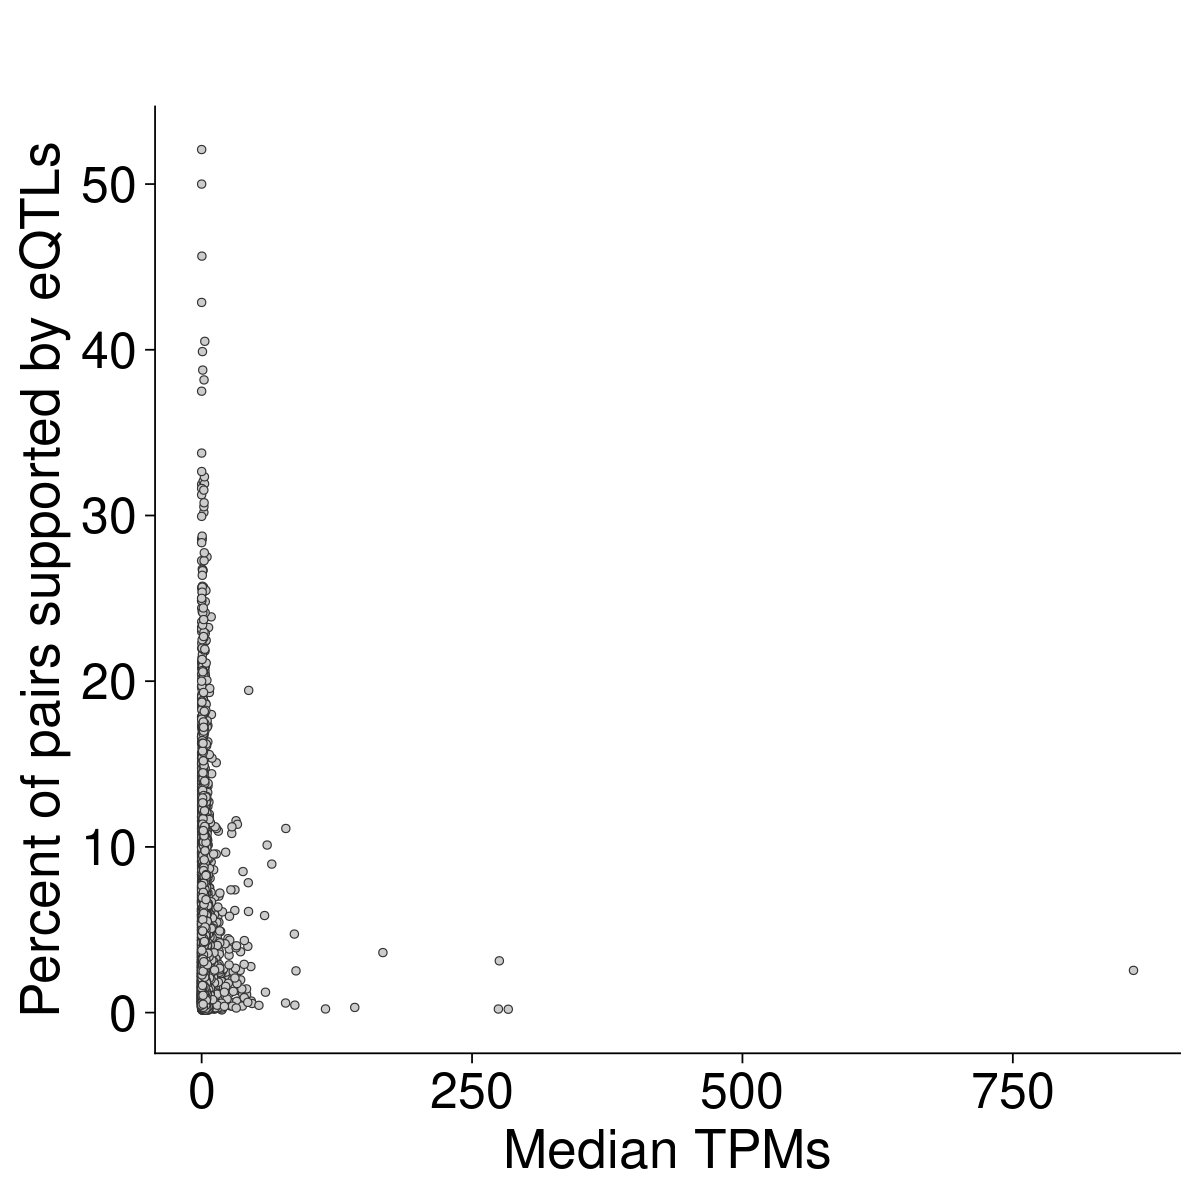

In [22]:
options(repr.plot.width=10, repr.plot.height=10)

percent_eqtl_pairs_plot <- ggplot(bidir_eqtl_gene_counts_meta,
                          aes(x=median, y=percent_eqtl)) +
geom_point(shape = 21, size=2, color='gray20', fill='gray80', alpha=1) + 
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Median TPMs") +
ylab("Percent of pairs supported by eQTLs") +
labs(fill=" ") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 36), 
      axis.title = element_text(size = 32), 
      axis.text = element_text(size = 30)) 

percent_eqtl_pairs_plot

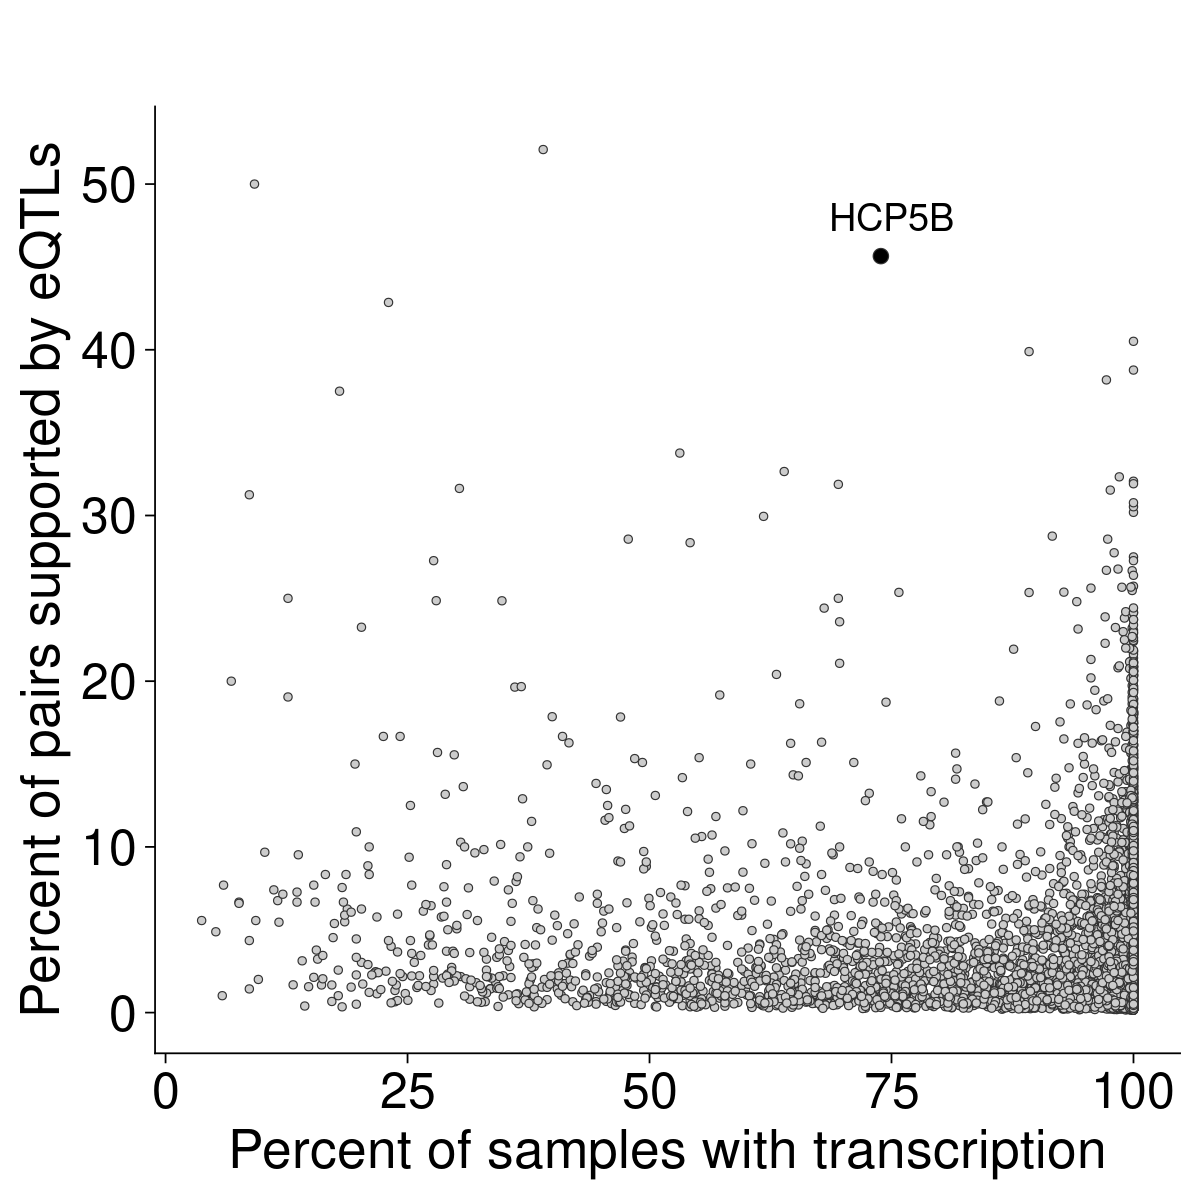

In [97]:
options(repr.plot.width=10, repr.plot.height=10)

percent_eqtl_pairs_plot <- ggplot(bidir_eqtl_gene_counts_meta,
                          aes(x=percent_transcribed, y=percent_eqtl)) +
geom_point(shape = 21, size=2, color='gray20', fill='gray80', alpha=1) + 
geom_point(data = subset(bidir_eqtl_gene_counts_meta, 
                        gene_id=="HCP5B:NR_031762.2"),
           aes(x=percent_transcribed, y=percent_eqtl),
           shape = 21, size=4, color='gray20', fill='black', alpha=1) + 
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Percent of samples with transcription") +
ylab("Percent of pairs supported by eQTLs") +
labs(fill=" ") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 36), 
      axis.title = element_text(size = 32), 
      axis.text = element_text(size = 30)) +
annotate("text", x = 75, y = 48, size=8, label = "HCP5B", color='black')

percent_eqtl_pairs_plot

In [99]:
ggsave(percent_eqtl_pairs_plot, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/percent_eqtl_pairs_plot.pdf',
      bg = "transparent")

ggsave(percent_eqtl_pairs_plot, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/percent_eqtl_pairs_plot.png',
      bg = "transparent")


In [79]:
subset(bidir_eqtl_gene_counts_meta, percent_eqtl > 30)

,gene_id,bidir_counts,eqtl_counts,percent_eqtl,chrom,start,stop,score,strand,length,⋯,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type,bidirectional_type
,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
84,ACADM:NM_000016.6,53,16,30.18868,chr1,75725458,75763679,.,+,38222,⋯,1748.591076,2.32835030,2.030068729,0.6546353,8.5741937,0.08657767,751,100.000000,genes,genes
1112,C4A:NM_007293.3,229,73,31.87773,chr6,31982806,32002681,.,+,19876,⋯,11.478828,0.01528472,0.007391102,2.2606295,0.3524715,0.00000000,522,69.507324,genes,genes
1421,CCT6P3:NR_033416.1,237,76,32.06751,chr7,65039103,65074713,.,+,35611,⋯,1242.254202,1.65413343,1.466155508,0.6198193,7.0588344,0.09516777,751,100.000000,genes,genes
1992,CRCP:NM_014478.5,353,143,40.50992,chr7,66115596,66154568,.,+,38973,⋯,2456.137964,3.27048997,2.912953768,0.5420281,13.8846344,0.29224391,751,100.000000,genes,genes
2686,EMB:NM_198449.3,183,73,39.89071,chr5,50396191,50440538,.,-,44348,⋯,1229.876152,1.63765133,0.752296164,1.9653656,38.3572823,0.00000000,670,89.214381,genes,genes
2872,FABP2:NM_000134.4,4,2,50.00000,chr4,119317249,119321388,.,-,4140,⋯,3.854102,0.00513196,0.000000000,7.4350364,0.7869939,0.00000000,69,9.187750,genes,genes
3077,FCER1A:NM_001387280.1,8,3,37.50000,chr1,159303085,159308202,.,+,5118,⋯,22.916670,0.03051487,0.000000000,9.2234004,5.5132243,0.00000000,135,17.976032,genes,genes
3307,GAPT:NM_001304428.2,7,3,42.85714,chr5,58492184,58496357,.,+,4174,⋯,280.116708,0.37299162,0.000000000,3.8838648,15.6992461,0.00000000,173,23.035952,genes,genes
3478,GNPDA2:NM_138335.3,49,19,38.77551,chr4,44701794,44725806,.,-,24013,⋯,887.993631,1.18241495,1.000421268,0.7516657,5.1114326,0.02004130,751,100.000000,genes,genes


In [105]:
subset(bidir_eqtl_gene_counts_meta, gene_id=="HCG18:NR_024052.2")

,gene_id,bidir_counts,eqtl_counts,percent_eqtl,chrom,start,stop,score,strand,length,⋯,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type,bidirectional_type
,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
3742,HCG18:NR_024052.2,352,62,17.61364,chr6,30287396,30326406,.,-,39011,⋯,4233.965,5.63777,5.096902,0.6998648,28.88084,0.007948066,751,100,genes,genes


In [107]:
subset(bidir_eqtl_gene_counts_meta, gene_id=="HCP5B:NR_031762.2")

,gene_id,bidir_counts,eqtl_counts,percent_eqtl,chrom,start,stop,score,strand,length,⋯,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type,bidirectional_type
,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
3755,HCP5B:NR_031762.2,184,84,45.65217,chr6,29871894,29873154,.,-,1261,⋯,416.1244,0.5540938,0.2281366,1.635703,6.205657,0,555,73.90146,genes,genes


## Percent of genes with GTEx eQTL

In [92]:
100*(nrow(bidir_eqtl_gene_counts_meta)/length(unique(corr_sig_strict_DT$transcript_1)))

[1] 38.77159

# Plot arches

## HCG18

In [26]:
sig_pairs_hcg18 <- get_pairs_pcc_bed6(corr_sig_strict_DT,
                                  stringent_sig_pair_gtex_overlaps_matched_tissue, 
                                  "HCG18:NR_024052.2")
nrow(sig_pairs_hcg18)
head(sig_pairs_hcg18)

[1] 676

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6,30326405,30326406,chr6,29636428,29636429,0.3598258,0,689.977
chr6,30326405,30326406,chr6,29638400,29638401,0.4451067,0,688.005
chr6,30326405,30326406,chr6,29641992,29641993,0.5126522,0,684.413
chr6,30326405,30326406,chr6,29645735,29645736,0.7196972,0,680.670
chr6,30326405,30326406,chr6,29648115,29648116,0.6221730,0,678.290
chr6,30326405,30326406,chr6,29649215,29649216,0.4441027,0,677.190


In [27]:
30327156-1000000
30327156+1000000

[1] 29327156

[1] 31327156

In [28]:
sig_pairs_hcg18_gtex <- subset(sig_pairs_hcg18, gtex==1)
nrow(sig_pairs_hcg18_gtex)
head(sig_pairs_hcg18_gtex, 2)

[1] 73

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6,30287396,30326406,chr6,29589606,29592046,0.4101317,1,697.790
chr6,30287396,30326406,chr6,29692701,29693387,0.5017289,1,594.695


Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]



genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



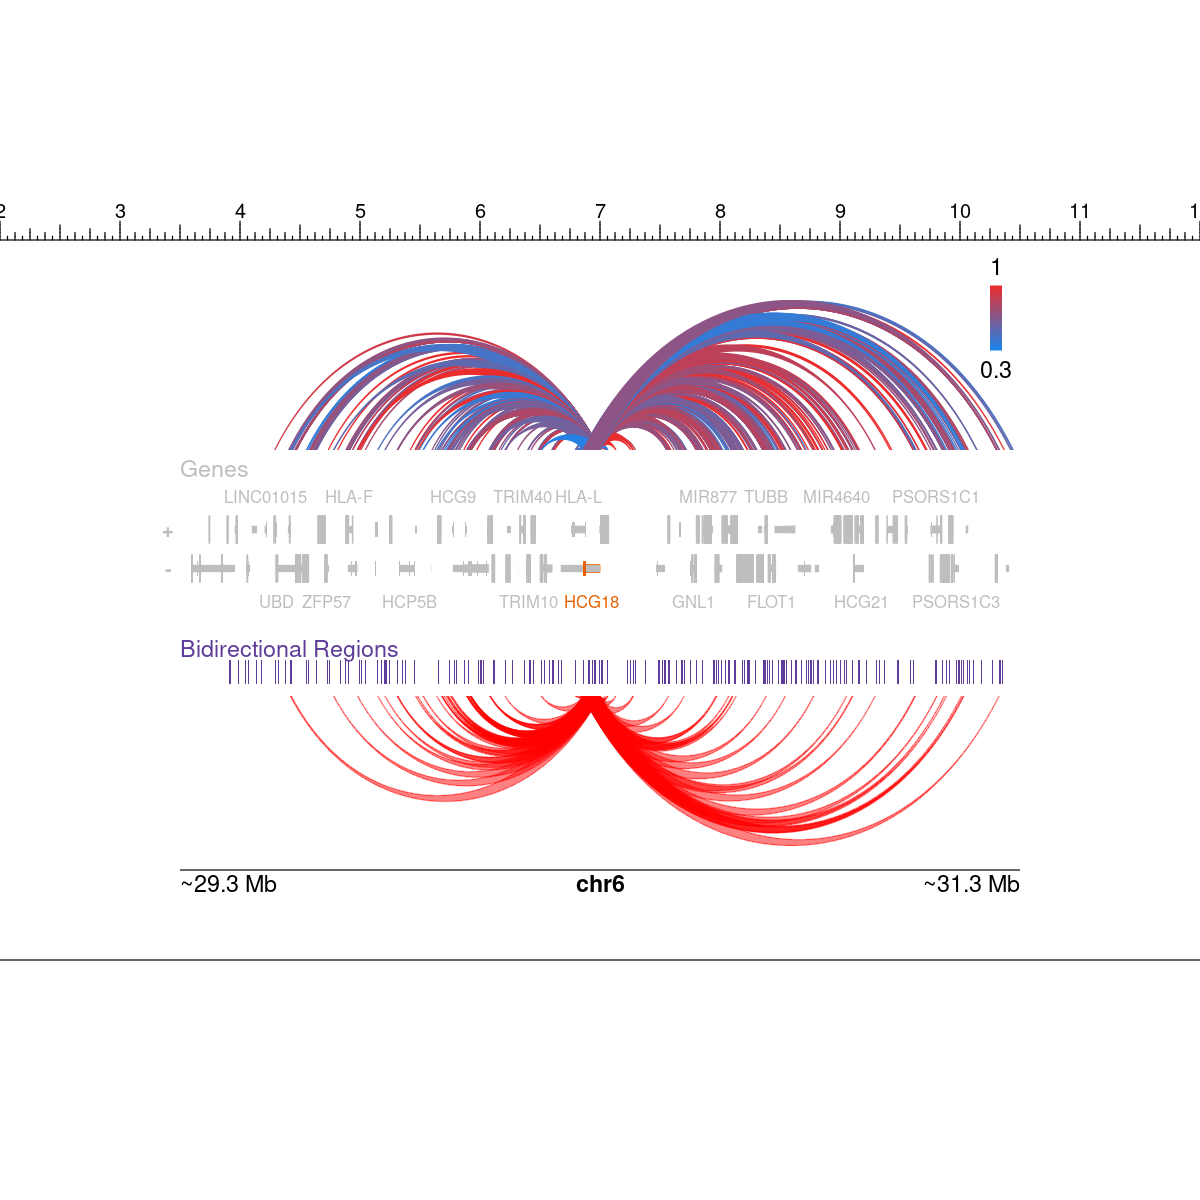

In [29]:
pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_hcg18$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_hcg18_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hcg18,
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_hcg18$length / max(sig_pairs_hcg18$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 14
)

## Add gene track
plotGenes(
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("HCG18"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectional Regions", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hcg18_gtex,
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_hcg18_gtex$length / max(sig_pairs_hcg18_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fontsize = 14,
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)




In [30]:
hcg18_gtex_Npairs <- nrow(unique(sig_pairs_hcg18_gtex[,c('transcript1_chrom',
                                                         'transcript1_start',
                                                         'transcript1_stop',
                                                         'transcript2_chrom',
                                                         'transcript2_start',
                                                         'transcript2_stop')]))

print(paste("Number of HCG18 GTEx pairs =", hcg18_gtex_Npairs))

[1] "Number of HCG18 GTEx pairs = 62"


In [31]:
hcg18_Npairs <- nrow(unique(sig_pairs_hcg18[,c('transcript1_chrom',
                                               'transcript1_start',
                                               'transcript1_stop',
                                               'transcript2_chrom',
                                               'transcript2_start',
                                               'transcript2_stop')]))

print(paste("Number of HCG18 ALL pairs =", hcg18_Npairs))

[1] "Number of HCG18 ALL pairs = 352"


In [32]:
hcg18_perc_gtex_pairs <- (hcg18_gtex_Npairs/hcg18_Npairs)*100
print(paste("Percent HCG18 GTEx pairs =", 
            signif(hcg18_perc_gtex_pairs,4),
            "%"))

[1] "Percent HCG18 GTEx pairs = 17.61 %"


In [100]:
pdf(file = "/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/hcg18_links_arches_plot_reviews.pdf", 
    width = 14,
    height = 6)


pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_hcg18$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_hcg18_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hcg18,
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_hcg18$length / max(sig_pairs_hcg18$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 14
)

## Add gene track
plotGenes(
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("HCG18"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectional Regions", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hcg18_gtex,
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_hcg18_gtex$length / max(sig_pairs_hcg18_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fontsize = 14,
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)

dev.off()

Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



png 
  2

## GABBR1

In [34]:
sig_pairs_gabbr1 <- get_pairs_pcc_bed6(corr_sig_strict_DT,
                                  stringent_sig_pair_gtex_overlaps_matched_tissue, 
                                  "GABBR1:NM_021903.3")
nrow(sig_pairs_gabbr1)
head(sig_pairs_gabbr1, 2)

[1] 564

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6,29627262,29627263,chr6,28627711,28627712,0.8171990,0,999.551
chr6,29627262,29627263,chr6,28657143,28657144,0.7364972,0,970.119


In [35]:
sig_pairs_gabbr1_gtex <- subset(sig_pairs_gabbr1, gtex==1)
nrow(sig_pairs_gabbr1_gtex)
head(sig_pairs_gabbr1_gtex, 2)

[1] 12

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6,29602237,29627263,chr6,28929014,28930596,0.3459661,1,673.223
chr6,29602237,29627263,chr6,29015951,29016473,0.3369970,1,586.286


In [36]:
29628013-1000000
29628013+1000000

[1] 28628013

[1] 30628013

Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



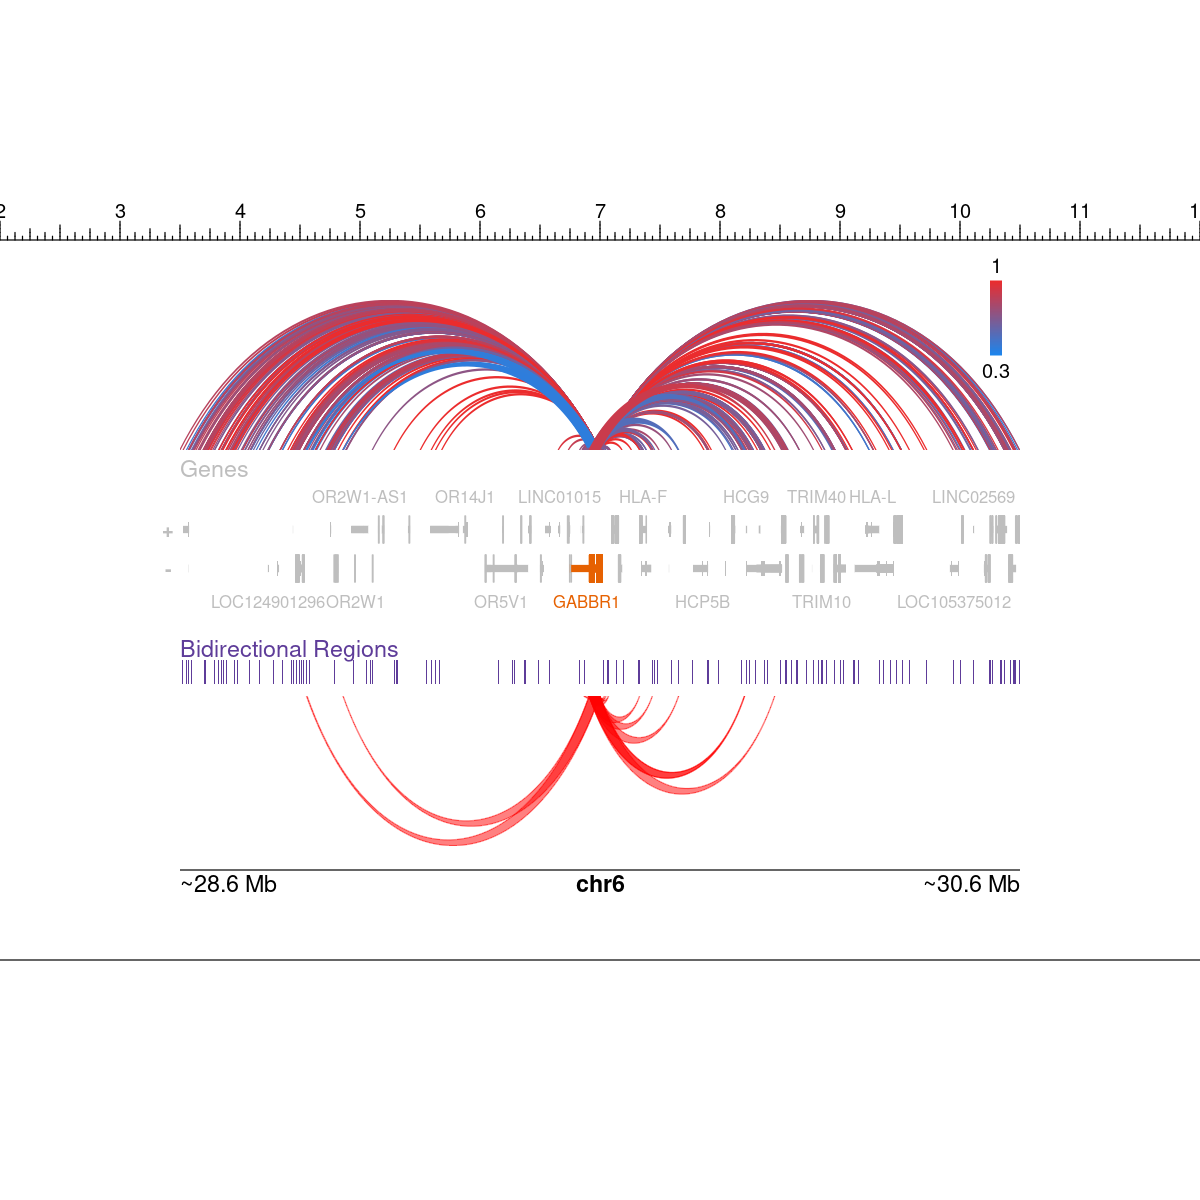

In [37]:
pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_gabbr1$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_gabbr1_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_gabbr1,
    chrom = "chr6", chromstart = 28628013, chromend = 30628013,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_gabbr1$length / max(sig_pairs_gabbr1$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 12
)

## Add gene track
plotGenes(
    chrom = "chr6", chromstart = 28628013, chromend = 30628013,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("GABBR1"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr6", chromstart = 28628013, chromend = 30628013,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectional Regions", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_gabbr1_gtex,
    chrom = "chr6", chromstart = 28628013, chromend = 30628013,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_gabbr1_gtex$length / max(sig_pairs_gabbr1_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr6", chromstart = 28628013, chromend = 30628013,
    assembly = "hg38",
    fontsize = 14,
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)

In [38]:
gabbr1_gtex_Npairs <- nrow(unique(sig_pairs_gabbr1_gtex[,c('transcript1_chrom',
                                                         'transcript1_start',
                                                         'transcript1_stop',
                                                         'transcript2_chrom',
                                                         'transcript2_start',
                                                         'transcript2_stop')]))

print(paste("Number of GABBR1 GTEx pairs =", gabbr1_gtex_Npairs))

[1] "Number of GABBR1 GTEx pairs = 12"


In [39]:
gabbr1_Npairs <- nrow(unique(sig_pairs_gabbr1[,c('transcript1_chrom',
                                               'transcript1_start',
                                               'transcript1_stop',
                                               'transcript2_chrom',
                                               'transcript2_start',
                                               'transcript2_stop')]))

print(paste("Number of GABBR1 ALL pairs =", gabbr1_Npairs))

[1] "Number of GABBR1 ALL pairs = 297"


In [40]:
gabbr1_perc_gtex_pairs <- (gabbr1_gtex_Npairs/gabbr1_Npairs)*100
print(paste("Percent GABBR1 GTEx pairs =", 
            signif(gabbr1_perc_gtex_pairs,4),
            "%"))

[1] "Percent GABBR1 GTEx pairs = 4.04 %"


## SUMO2

In [41]:
sig_pairs_sumo2 <- get_pairs_pcc_bed6(corr_sig_strict_DT,
                                  stringent_sig_pair_gtex_overlaps_matched_tissue, 
                                  "SUMO2:NM_006937.4")
nrow(sig_pairs_sumo2)
head(sig_pairs_sumo2)

[1] 992

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr17,75182208,75182209,chr17,74504218,74504219,0.5929213,0,677.990
chr17,75182208,75182209,chr17,75185292,75185293,0.3611372,0,3.084
chr17,75182208,75182209,chr17,75186305,75186306,0.4082489,0,4.097
chr17,75182208,75182209,chr17,75201225,75201226,0.4445744,0,19.017
chr17,75182208,75182209,chr17,75201910,75201911,0.3091474,0,19.702
chr17,75182208,75182209,chr17,75202885,75202886,0.3446547,0,20.677


In [42]:
sig_pairs_sumo2_gtex <- subset(sig_pairs_sumo2, gtex==1)
nrow(sig_pairs_sumo2_gtex)
head(sig_pairs_sumo2_gtex, 2)

[1] 17

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr17,75165585,75182209,chr17,75032369,75032679,0.3811087,1,133.216
chr17,75165585,75182209,chr17,75130758,75131174,0.4143270,1,34.827


In [43]:
75182959-1000000
75182959+1000000

[1] 74182959

[1] 76182959

Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



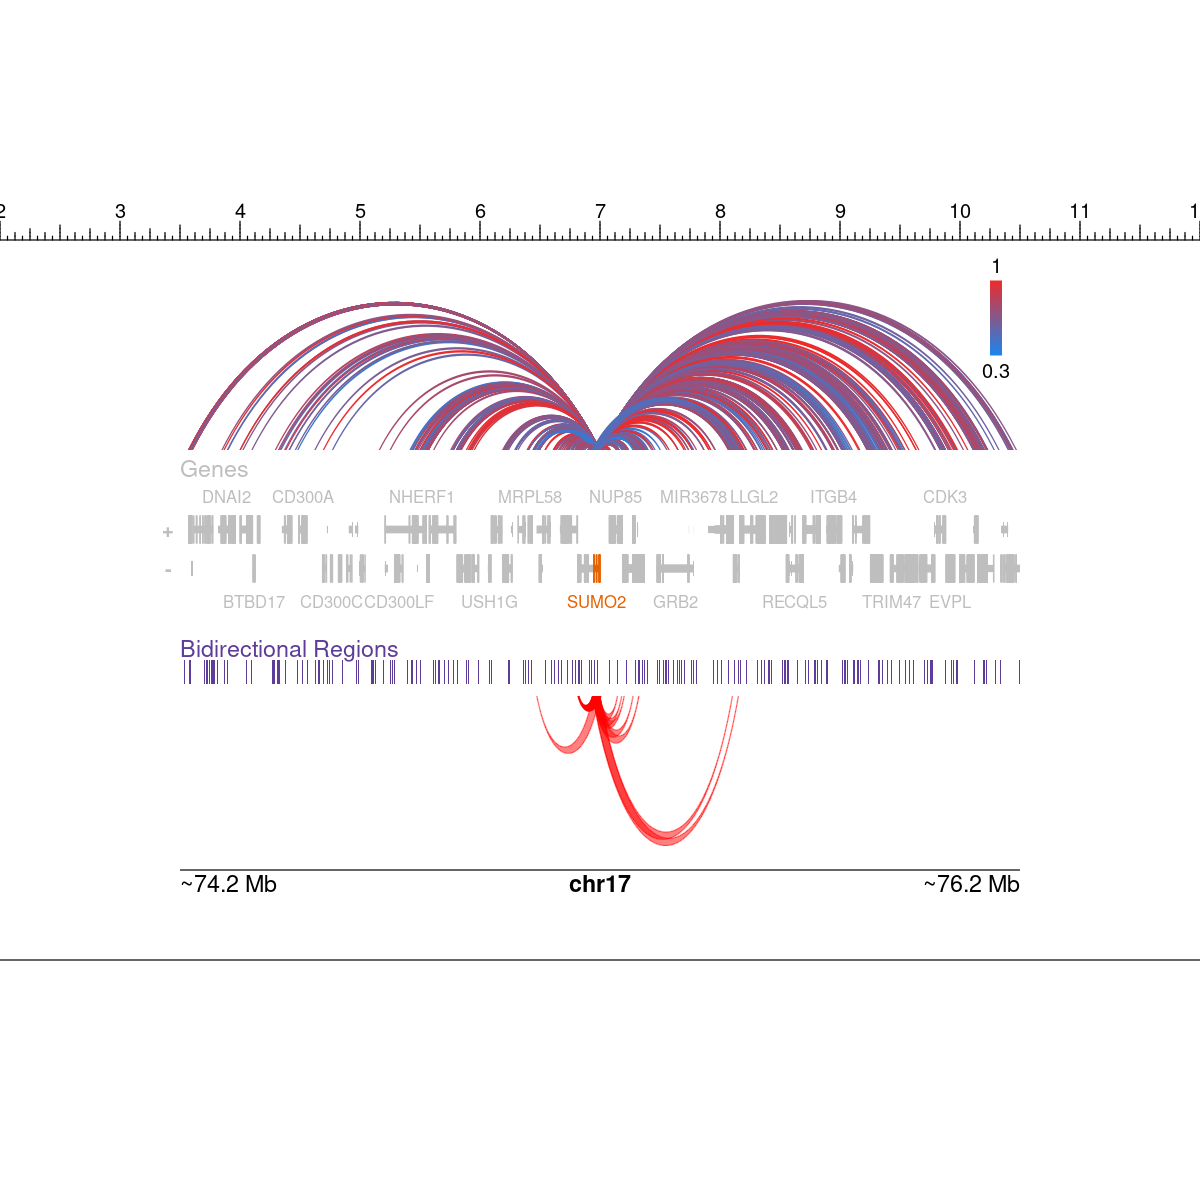

In [44]:
pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_sumo2$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_sumo2_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_sumo2,
    chrom = "chr17", chromstart = 74182959, chromend = 76182959,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_sumo2$length / max(sig_pairs_sumo2$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 12
)

## Add gene track
plotGenes(
    chrom = "chr17", chromstart = 74182959, chromend = 76182959,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("SUMO2"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr17", chromstart = 74182959, chromend = 76182959,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectional Regions", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_sumo2_gtex,
    chrom = "chr17", chromstart = 74182959, chromend = 76182959,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_sumo2_gtex$length / max(sig_pairs_sumo2_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr17", chromstart = 74182959, chromend = 76182959,
    assembly = "hg38",
    fontsize = 14,
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)


In [45]:
sumo2_gtex_Npairs <- nrow(unique(sig_pairs_sumo2_gtex[,c('transcript1_chrom',
                                                         'transcript1_start',
                                                         'transcript1_stop',
                                                         'transcript2_chrom',
                                                         'transcript2_start',
                                                         'transcript2_stop')]))

print(paste("Number of SUMO2 GTEx pairs =", sumo2_gtex_Npairs))

[1] "Number of SUMO2 GTEx pairs = 11"


In [46]:
sumo2_Npairs <- nrow(unique(sig_pairs_sumo2[,c('transcript1_chrom',
                                               'transcript1_start',
                                               'transcript1_stop',
                                               'transcript2_chrom',
                                               'transcript2_start',
                                               'transcript2_stop')]))

print(paste("Number of SUMO2 ALL pairs =", sumo2_Npairs))

[1] "Number of SUMO2 ALL pairs = 415"


In [47]:
sumo2_perc_gtex_pairs <- (sumo2_gtex_Npairs/sumo2_Npairs)*100
print(paste("Percent SUMO2 GTEx pairs =", 
            signif(sumo2_perc_gtex_pairs,4),
            "%"))

[1] "Percent SUMO2 GTEx pairs = 2.651 %"


## DRAM1

In [48]:
sig_pairs_dram1 <- get_pairs_pcc_bed6(corr_sig_strict_DT,
                                  stringent_sig_pair_gtex_overlaps_matched_tissue, 
                                  "DRAM1:NM_018370.3")
nrow(sig_pairs_dram1)
head(sig_pairs_dram1)

[1] 190

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr12,101878329,101878330,chr12,101279549,101279550,0.4967849,0,598.780
chr12,101878329,101878330,chr12,101850368,101850369,0.5914025,0,27.961
chr12,101878329,101878330,chr12,101855577,101855578,0.4585326,0,22.752
chr12,101878329,101878330,chr12,101857541,101857542,0.7300259,0,20.788
chr12,101878329,101878330,chr12,101859851,101859852,0.6809940,0,18.478
chr12,101878329,101878330,chr12,101876566,101876567,0.7573085,0,1.763


In [49]:
sig_pairs_dram1_gtex <- subset(sig_pairs_dram1, gtex==1)
nrow(sig_pairs_dram1_gtex)
head(sig_pairs_dram1_gtex, 2)

[1] 6

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr12,101878329,101923612,chr12,101740484,101741006,0.3872356,1,137.845
chr12,101878329,101923612,chr12,101877045,101877339,0.6674673,1,1.284


In [50]:
101877579-1000000
101877579+1000000

[1] 100877579

[1] 102877579

Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



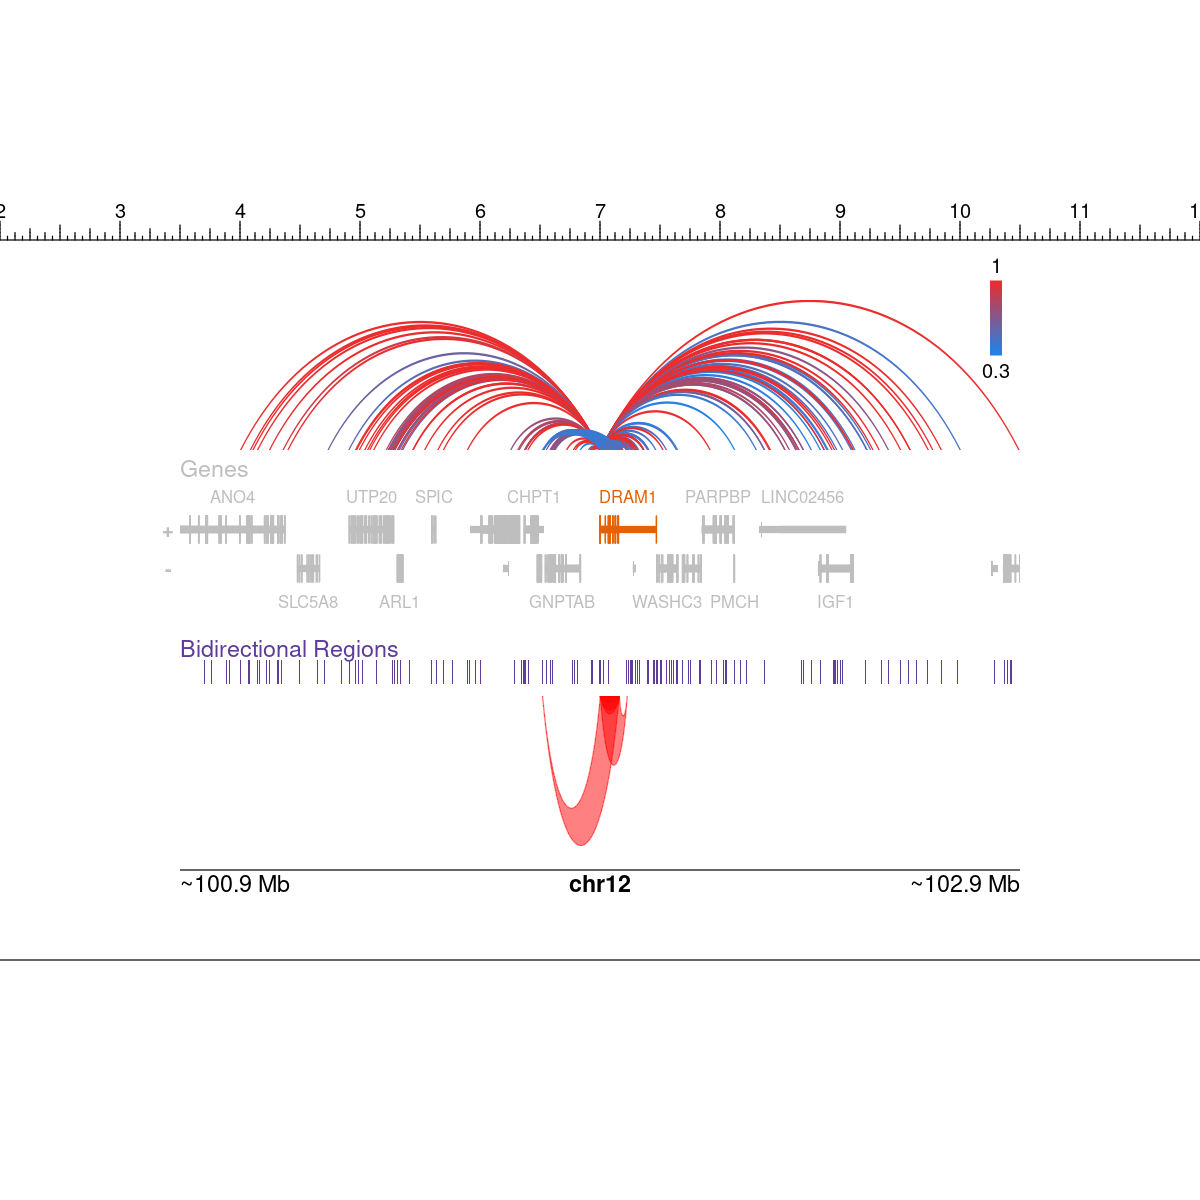

In [51]:
pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_dram1$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_dram1_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_dram1,
    chrom = "chr12", chromstart = 100877579, chromend = 102877579,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_dram1$length / max(sig_pairs_dram1$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 12
)

## Add gene track
plotGenes(
    chrom = "chr12", chromstart = 100877579, chromend = 102877579,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("DRAM1"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr12", chromstart = 100877579, chromend = 102877579,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectional Regions", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_dram1_gtex,
    chrom = "chr12", chromstart = 100877579, chromend = 102877579,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_dram1_gtex$length / max(sig_pairs_dram1_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr12", chromstart = 100877579, chromend = 102877579,
    assembly = "hg38",
    fontsize = 14,
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)

In [52]:
dram1_gtex_Npairs <- nrow(unique(sig_pairs_dram1_gtex[,c('transcript1_chrom',
                                                         'transcript1_start',
                                                         'transcript1_stop',
                                                         'transcript2_chrom',
                                                         'transcript2_start',
                                                         'transcript2_stop')]))

print(paste("Number of DRAM1 GTEx pairs =", dram1_gtex_Npairs))

[1] "Number of DRAM1 GTEx pairs = 6"


In [53]:
dram1_Npairs <- nrow(unique(sig_pairs_dram1[,c('transcript1_chrom',
                                               'transcript1_start',
                                               'transcript1_stop',
                                               'transcript2_chrom',
                                               'transcript2_start',
                                               'transcript2_stop')]))

print(paste("Number of DRAM1 ALL pairs =", dram1_Npairs))

[1] "Number of DRAM1 ALL pairs = 152"


In [54]:
dram1_perc_gtex_pairs <- (dram1_gtex_Npairs/dram1_Npairs)*100
print(paste("Percent DRAM1 GTEx pairs =", 
            signif(dram1_perc_gtex_pairs,4),
            "%"))

[1] "Percent DRAM1 GTEx pairs = 3.947 %"


## HOXB3

In [57]:
sig_pairs_hoxb3 <- get_pairs_pcc_bed6(corr_sig_strict_DT,
                                  stringent_sig_pair_gtex_overlaps_matched_tissue, 
                                  "HOXB3:NM_002146.4")
nrow(sig_pairs_hoxb3)
head(sig_pairs_hoxb3)

[1] 615

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr17,48573697,48573698,chr17,47859400,47859401,0.5108166,0,714.297
chr17,48573697,48573698,chr17,47861424,47861425,0.3949098,0,712.273
chr17,48573697,48573698,chr17,47863184,47863185,0.3968243,0,710.513
chr17,48573697,48573698,chr17,47866915,47866916,0.5786469,0,706.782
chr17,48573697,48573698,chr17,47869303,47869304,0.5157527,0,704.394
chr17,48573697,48573698,chr17,47870225,47870226,0.3874228,0,703.472


In [58]:
sig_pairs_hoxb3_gtex <- subset(sig_pairs_hoxb3, gtex==1)
nrow(sig_pairs_hoxb3_gtex)
head(sig_pairs_hoxb3_gtex, 2)

[1] 24

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr17,48548869,48573698,chr17,47844360,47844670,0.7036300,1,704.509
chr17,48548869,48573698,chr17,47846602,47847128,0.6329146,1,702.267


In [59]:
#chr17:48548870-48574448 (-)

48574448-1000000
48574448+1000000

[1] 47574448

[1] 49574448

Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



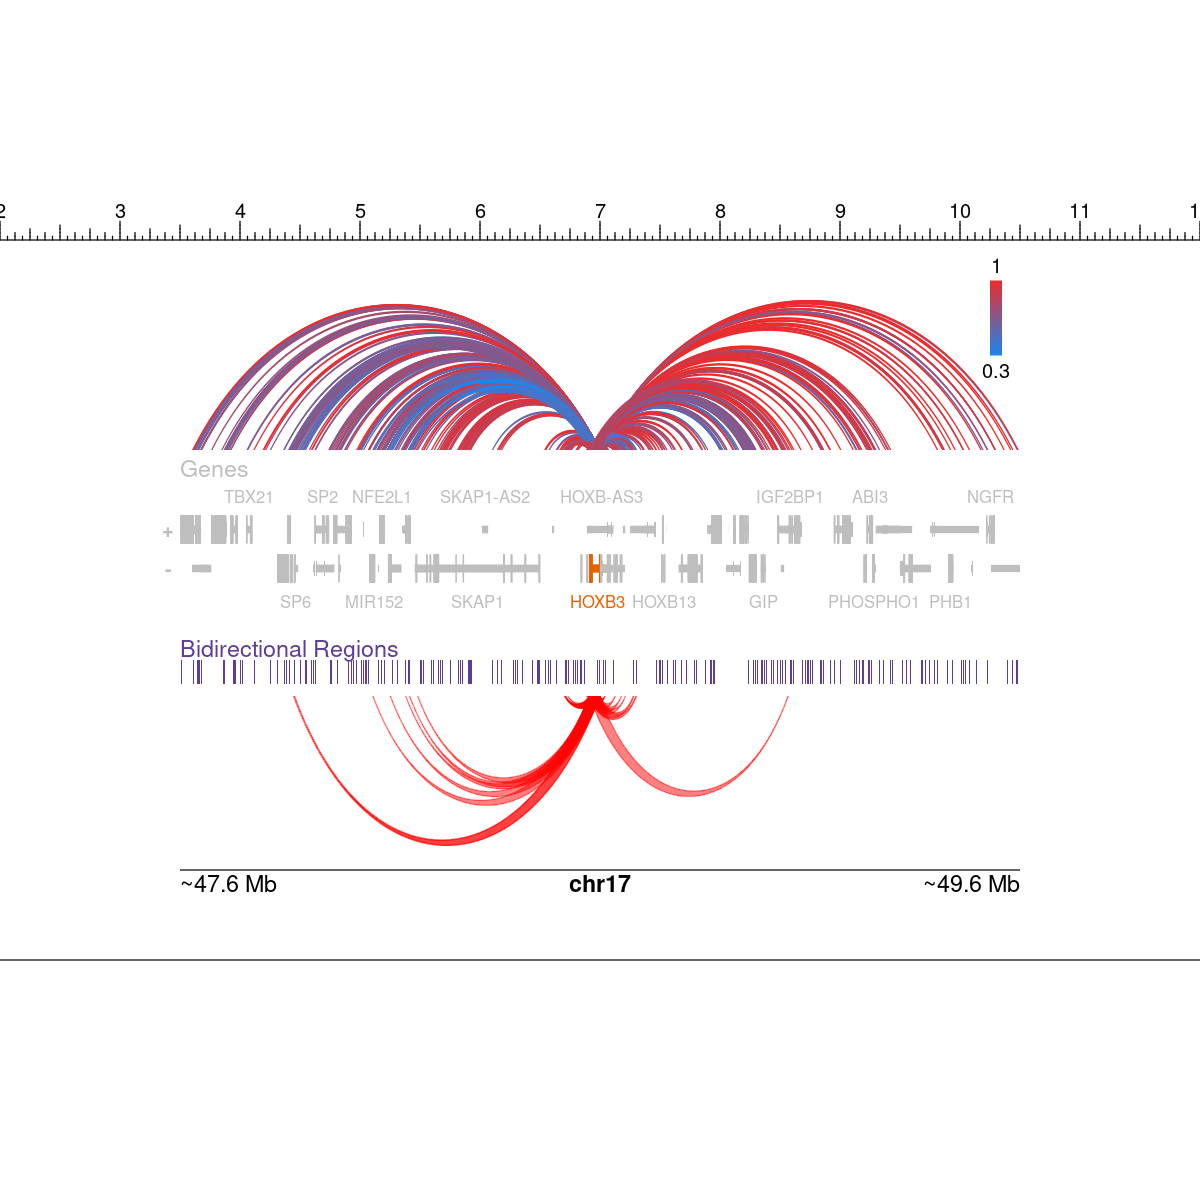

In [60]:
pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_hoxb3$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_hoxb3_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hoxb3,
    chrom = "chr17", chromstart = 47574448, chromend = 49574448,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_hoxb3$length / max(sig_pairs_hoxb3$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 12
)

## Add gene track
plotGenes(
    chrom = "chr17", chromstart = 47574448, chromend = 49574448,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("HOXB3"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr17", chromstart = 47574448, chromend = 49574448,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectional Regions", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hoxb3_gtex,
    chrom = "chr17", chromstart = 47574448, chromend = 49574448,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_hoxb3_gtex$length / max(sig_pairs_hoxb3_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr17", chromstart = 47574448, chromend = 49574448,
    assembly = "hg38",
    fontsize = 14,
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)


In [61]:
hoxb3_gtex_Npairs <- nrow(unique(sig_pairs_hoxb3_gtex[,c('transcript1_chrom',
                                                         'transcript1_start',
                                                         'transcript1_stop',
                                                         'transcript2_chrom',
                                                         'transcript2_start',
                                                         'transcript2_stop')]))

print(paste("Number of HOXB3 GTEx pairs =", hoxb3_gtex_Npairs))

[1] "Number of HOXB3 GTEx pairs = 20"


In [62]:
hoxb3_Npairs <- nrow(unique(sig_pairs_hoxb3[,c('transcript1_chrom',
                                               'transcript1_start',
                                               'transcript1_stop',
                                               'transcript2_chrom',
                                               'transcript2_start',
                                               'transcript2_stop')]))

print(paste("Number of HOXB3 ALL pairs =", hoxb3_Npairs))

[1] "Number of HOXB3 ALL pairs = 389"


In [63]:
hoxb3_perc_gtex_pairs <- (hoxb3_gtex_Npairs/hoxb3_Npairs)*100
print(paste("Percent HOXB3 GTEx pairs =", 
            signif(hoxb3_perc_gtex_pairs,4),
            "%"))

[1] "Percent HOXB3 GTEx pairs = 5.141 %"


## NOTCH4

In [65]:
#NOTCH4:NM_004557.4 (chr6:32194843-32224067 (-))
sig_pairs_notch4 <- get_pairs_pcc_bed6(corr_sig_strict_DT,
                                  stringent_sig_pair_gtex_overlaps_matched_tissue, 
                                  "NOTCH4:NM_004557.4")
nrow(sig_pairs_notch4)
head(sig_pairs_notch4)

[1] 487

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6,32223316,32223317,chr6,32437661,32437662,0.6903754,0,214.345
chr6,32223316,32223317,chr6,32438261,32438262,0.6077338,0,214.945
chr6,32223316,32223317,chr6,32461460,32461461,0.5409134,0,238.144
chr6,32223316,32223317,chr6,32471809,32471810,0.6856326,0,248.493
chr6,32223316,32223317,chr6,32473573,32473574,0.6546377,0,250.257
chr6,32223316,32223317,chr6,32591059,32591060,0.5772285,0,367.743


In [66]:
32224067-1000000
32224067+1000000

[1] 31224067

[1] 33224067

In [67]:
sig_pairs_notch4_gtex <- subset(sig_pairs_notch4, gtex==1)
nrow(sig_pairs_notch4_gtex)
head(sig_pairs_notch4_gtex, 2)

[1] 67

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6,32194842,32223317,chr6,31271950,31272366,0.6561397,1,922.892
chr6,32194842,32223317,chr6,31272926,31273346,0.7248138,1,921.916


Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



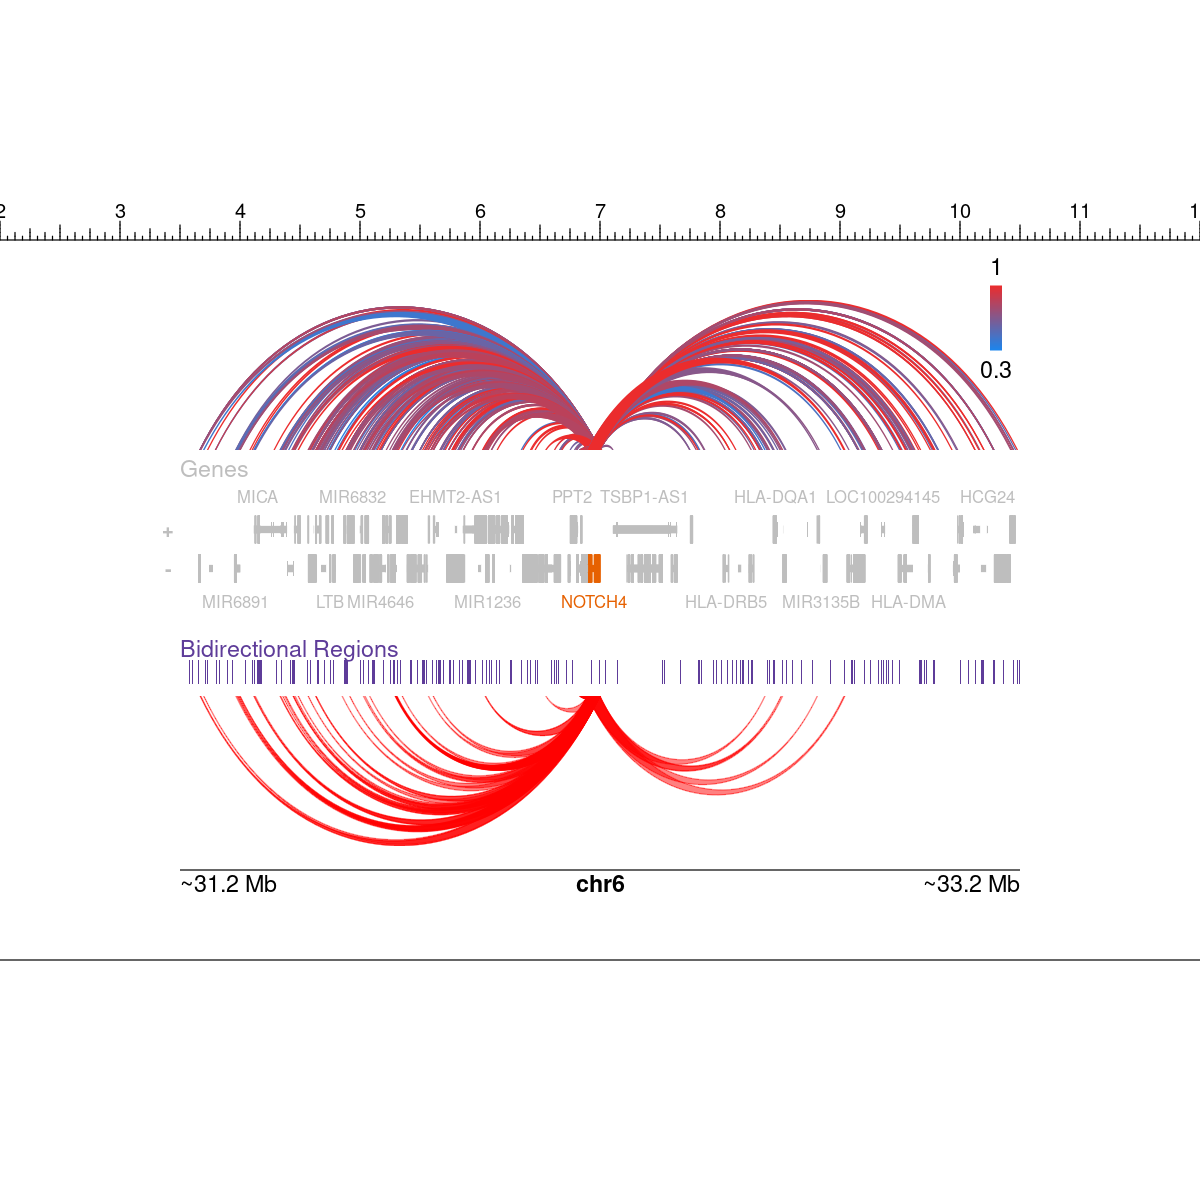

In [68]:
pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_notch4$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_notch4_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_notch4,
    chrom = "chr6", chromstart = 31224067, chromend = 33224067,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_notch4$length / max(sig_pairs_notch4$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 14
)

## Add gene track
plotGenes(
    chrom = "chr6", chromstart = 31224067, chromend = 33224067,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("NOTCH4"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr6", chromstart = 31224067, chromend = 33224067,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectional Regions", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_notch4_gtex,
    chrom = "chr6", chromstart = 31224067, chromend = 33224067,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_notch4_gtex$length / max(sig_pairs_notch4_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr6", chromstart = 31224067, chromend = 33224067,
    assembly = "hg38",
    fontsize = 14,
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)



In [69]:
notch4_gtex_Npairs <- nrow(unique(sig_pairs_notch4_gtex[,c('transcript1_chrom',
                                                         'transcript1_start',
                                                         'transcript1_stop',
                                                         'transcript2_chrom',
                                                         'transcript2_start',
                                                         'transcript2_stop')]))

print(paste("Number of NOTCH4 GTEx pairs =", notch4_gtex_Npairs))

[1] "Number of NOTCH4 GTEx pairs = 49"


In [70]:
notch4_Npairs <- nrow(unique(sig_pairs_notch4[,c('transcript1_chrom',
                                               'transcript1_start',
                                               'transcript1_stop',
                                               'transcript2_chrom',
                                               'transcript2_start',
                                               'transcript2_stop')]))

print(paste("Number of NOTCH4 ALL pairs =", notch4_Npairs))

[1] "Number of NOTCH4 ALL pairs = 307"


In [71]:
notch4_perc_gtex_pairs <- (notch4_gtex_Npairs/notch4_Npairs)*100
print(paste("Percent NOTCH4 GTEx pairs =", 
            signif(notch4_perc_gtex_pairs,4),
            "%"))

[1] "Percent NOTCH4 GTEx pairs = 15.96 %"


In [101]:
pdf(file = "/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/notch4_links_arches_plot_reviews.pdf", 
    width = 14,
    height = 6)

pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_notch4$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_notch4_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_notch4,
    chrom = "chr6", chromstart = 31224067, chromend = 33224067,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_notch4$length / max(sig_pairs_notch4$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 14
)

## Add gene track
plotGenes(
    chrom = "chr6", chromstart = 31224067, chromend = 33224067,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("NOTCH4"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr6", chromstart = 31224067, chromend = 33224067,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectional Regions", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_notch4_gtex,
    chrom = "chr6", chromstart = 31224067, chromend = 33224067,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_notch4_gtex$length / max(sig_pairs_notch4_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr6", chromstart = 31224067, chromend = 33224067,
    assembly = "hg38",
    fontsize = 14,
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)



dev.off()

Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



png 
  2

## CDK10

In [72]:
sig_pairs_cdk10 <- get_pairs_pcc_bed6(corr_sig_strict_DT,
                                  stringent_sig_pair_gtex_overlaps_matched_tissue, 
                                  "CDK10:NM_052987.4")
nrow(sig_pairs_cdk10)
head(sig_pairs_cdk10)

[1] 1079

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr16,89687438,89687439,chr16,88788310,88788311,0.5023139,0,899.128
chr16,89687438,89687439,chr16,88792186,88792187,0.5105857,0,895.252
chr16,89687438,89687439,chr16,88792922,88792923,0.3731513,0,894.516
chr16,89687438,89687439,chr16,89018829,89018830,0.5142283,0,668.609
chr16,89687438,89687439,chr16,89042150,89042151,0.4102860,0,645.288
chr16,89687438,89687439,chr16,89049501,89049502,0.4366284,0,637.937


In [73]:
#CDK10:NM_052987.4 (chr16:89686689-89696354 (+))

89686689-1000000
89686689+1000000

[1] 88686689

[1] 90686689

In [74]:
sig_pairs_cdk10_gtex <- subset(sig_pairs_cdk10, gtex==1)
nrow(sig_pairs_cdk10_gtex)
head(sig_pairs_cdk10_gtex, 2)

[1] 187

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr16,89687438,89696354,chr16,88708410,88708744,0.6535361,1,979.028
chr16,89687438,89696354,chr16,88710012,88710334,0.6352501,1,977.426


Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



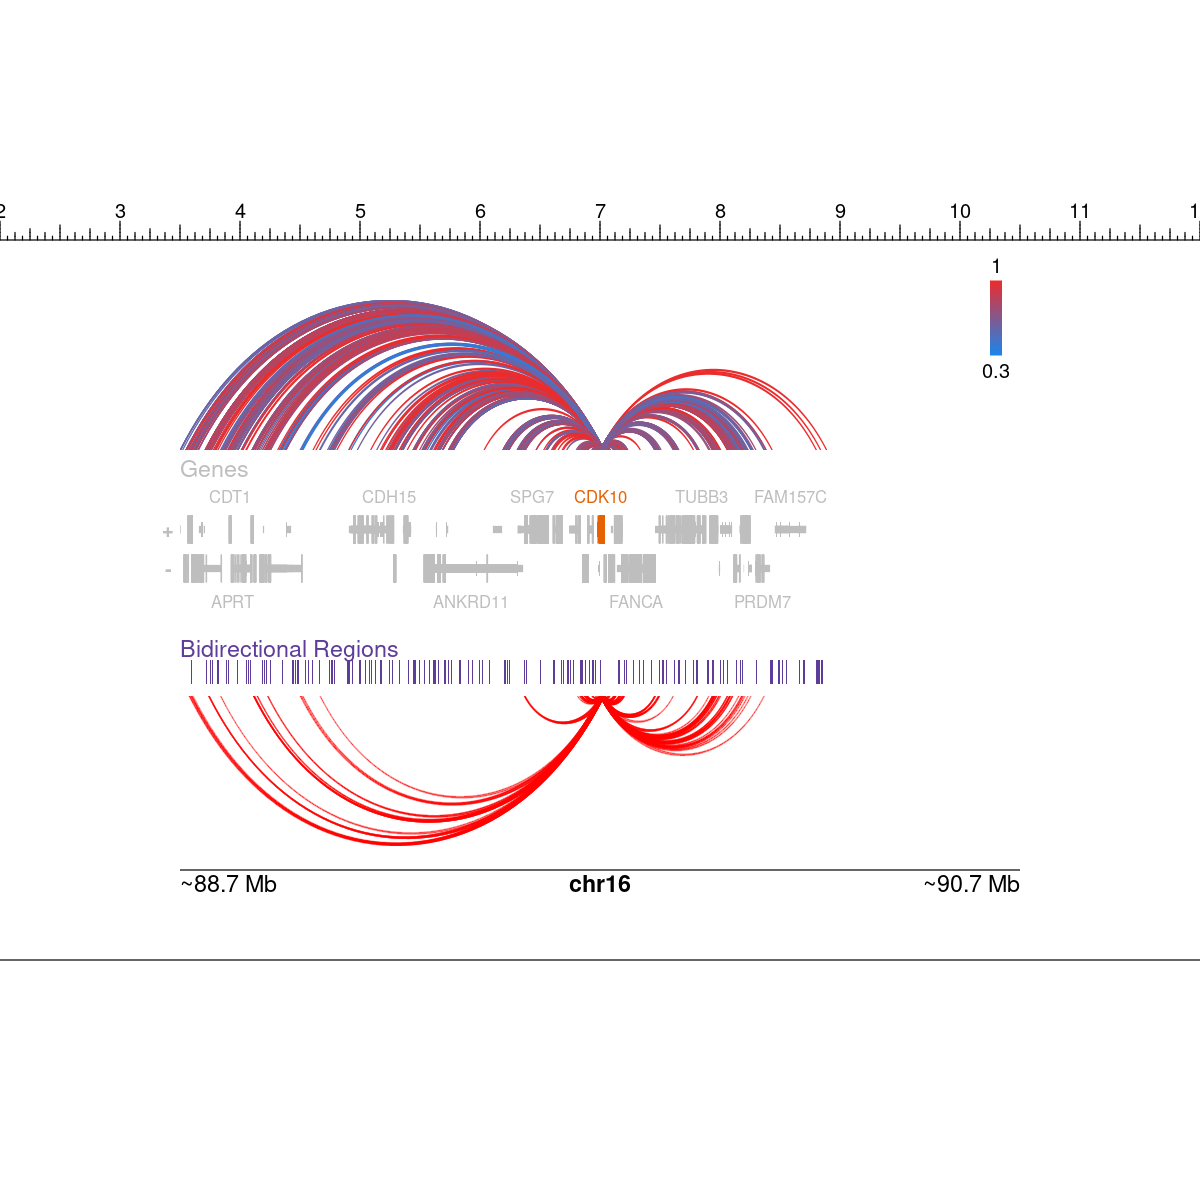

In [75]:
pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_cdk10$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_cdk10_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_cdk10,
    chrom = "chr16", chromstart = 88686689, chromend = 90686689,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_cdk10$length / max(sig_pairs_cdk10$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 12
)

## Add gene track
plotGenes(
    chrom = "chr16", chromstart = 88686689, chromend = 90686689,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("CDK10"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr16", chromstart = 88686689, chromend = 90686689,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectional Regions", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_cdk10_gtex,
    chrom = "chr16", chromstart = 88686689, chromend = 90686689,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_cdk10_gtex$length / max(sig_pairs_cdk10_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr16", chromstart = 88686689, chromend = 90686689,
    assembly = "hg38",
    fontsize = 14,
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)


In [76]:
cdk10_gtex_Npairs <- nrow(unique(sig_pairs_cdk10_gtex[,c('transcript1_chrom',
                                                         'transcript1_start',
                                                         'transcript1_stop',
                                                         'transcript2_chrom',
                                                         'transcript2_start',
                                                         'transcript2_stop')]))

print(paste("Number of CDK10 GTEx pairs =", cdk10_gtex_Npairs))

[1] "Number of CDK10 GTEx pairs = 76"


In [77]:
cdk10_Npairs <- nrow(unique(sig_pairs_cdk10[,c('transcript1_chrom',
                                               'transcript1_start',
                                               'transcript1_stop',
                                               'transcript2_chrom',
                                               'transcript2_start',
                                               'transcript2_stop')]))

print(paste("Number of CDK10 ALL pairs =", cdk10_Npairs))

[1] "Number of CDK10 ALL pairs = 391"


In [78]:
cdk10_perc_gtex_pairs <- (cdk10_gtex_Npairs/cdk10_Npairs)*100
print(paste("Percent CDK10 GTEx pairs =", 
            signif(cdk10_perc_gtex_pairs,4),
            "%"))

[1] "Percent CDK10 GTEx pairs = 19.44 %"


In [102]:
pdf(file = "/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/cdk10_links_arches_plot_reviews.pdf", 
    width = 14,
    height = 6)

pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_cdk10$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_cdk10_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_cdk10,
    chrom = "chr16", chromstart = 88686689, chromend = 90686689,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_cdk10$length / max(sig_pairs_cdk10$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 12
)

## Add gene track
plotGenes(
    chrom = "chr16", chromstart = 88686689, chromend = 90686689,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("CDK10"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr16", chromstart = 88686689, chromend = 90686689,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectional Regions", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_cdk10_gtex,
    chrom = "chr16", chromstart = 88686689, chromend = 90686689,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_cdk10_gtex$length / max(sig_pairs_cdk10_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr16", chromstart = 88686689, chromend = 90686689,
    assembly = "hg38",
    fontsize = 14,
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)


dev.off()

Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



png 
  2

## HCP5B

In [80]:
#HCP5B:NR_031762.2
# chr6:29871895-29873783 (-)
sig_pairs_hcp5b <- get_pairs_pcc_bed6(corr_sig_strict_DT,
                                  stringent_sig_pair_gtex_overlaps_matched_tissue, 
                                  "HCP5B:NR_031762.2")
nrow(sig_pairs_hcp5b)
head(sig_pairs_hcp5b)


[1] 229

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6,29873153,29873154,chr6,28940955,28940956,0.4464379,0,932.198
chr6,29873153,29873154,chr6,29650055,29650056,0.4844970,0,223.098
chr6,29873153,29873154,chr6,29965910,29965911,0.5466076,0,92.757
chr6,29873153,29873154,chr6,30216432,30216433,0.5354087,0,343.279
chr6,29873153,29873154,chr6,28995735,28995736,0.4724737,0,877.418
chr6,29873153,29873154,chr6,30228172,30228173,0.6222035,0,355.019


In [81]:
29873783-1000000
29873783+1000000

[1] 28873783

[1] 30873783

In [84]:
sig_pairs_hcp5b_gtex <- subset(sig_pairs_hcp5b, gtex==1)
nrow(sig_pairs_hcp5b_gtex)
head(sig_pairs_hcp5b_gtex, 2)

[1] 110

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6,29871894,29873154,chr6,28898243,28898595,0.3336457,1,973.651
chr6,29871894,29873154,chr6,28898243,28898595,0.5921430,1,973.651


Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



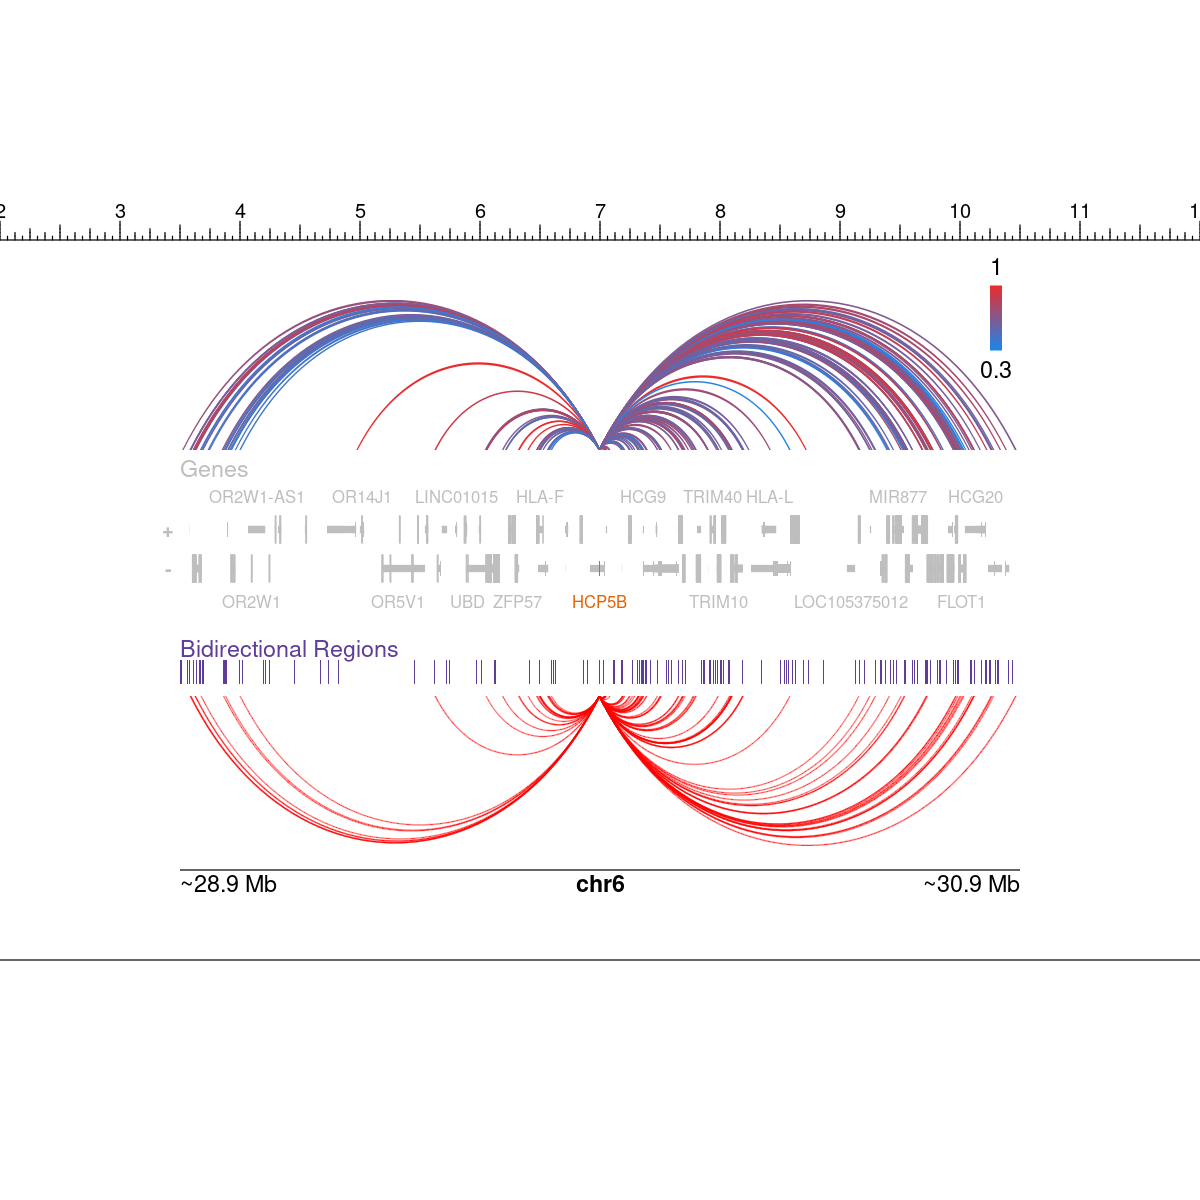

In [85]:
pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_hcp5b$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_hcp5b_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hcp5b,
    chrom = "chr6", chromstart = 28873783, chromend = 30873783,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_hcp5b$length / max(sig_pairs_hcp5b$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 14
)

## Add gene track
plotGenes(
    chrom = "chr6", chromstart = 28873783, chromend = 30873783,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("HCP5B"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr6", chromstart = 28873783, chromend = 30873783,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectional Regions", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hcp5b_gtex,
    chrom = "chr6", chromstart = 28873783, chromend = 30873783,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_hcp5b_gtex$length / max(sig_pairs_hcp5b_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr6", chromstart = 28873783, chromend = 30873783,
    assembly = "hg38",
    fontsize = 14,
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)


In [86]:
hcp5b_gtex_Npairs <- nrow(unique(sig_pairs_hcp5b_gtex[,c('transcript1_chrom',
                                                         'transcript1_start',
                                                         'transcript1_stop',
                                                         'transcript2_chrom',
                                                         'transcript2_start',
                                                         'transcript2_stop')]))

print(paste("Number of HCP5B GTEx pairs =", hcp5b_gtex_Npairs))

[1] "Number of HCP5B GTEx pairs = 84"


In [87]:
hcp5b_Npairs <- nrow(unique(sig_pairs_hcp5b[,c('transcript1_chrom',
                                               'transcript1_start',
                                               'transcript1_stop',
                                               'transcript2_chrom',
                                               'transcript2_start',
                                               'transcript2_stop')]))

print(paste("Number of HCP5B ALL pairs =", hcp5b_Npairs))

[1] "Number of HCP5B ALL pairs = 184"


In [88]:
hcp5b_perc_gtex_pairs <- (hcp5b_gtex_Npairs/hcp5b_Npairs)*100
print(paste("Percent HCP5B GTEx pairs =", 
            signif(hcp5b_perc_gtex_pairs,4),
            "%"))

[1] "Percent HCP5B GTEx pairs = 45.65 %"


In [103]:
pdf(file = "/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/hcp5b_links_arches_plot_reviews.pdf", 
    width = 14,
    height = 6)

pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_hcp5b$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_hcp5b_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hcp5b,
    chrom = "chr6", chromstart = 28873783, chromend = 30873783,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_hcp5b$length / max(sig_pairs_hcp5b$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 14
)

## Add gene track
plotGenes(
    chrom = "chr6", chromstart = 28873783, chromend = 30873783,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("HCP5B"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr6", chromstart = 28873783, chromend = 30873783,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectional Regions", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hcp5b_gtex,
    chrom = "chr6", chromstart = 28873783, chromend = 30873783,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_hcp5b_gtex$length / max(sig_pairs_hcp5b_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr6", chromstart = 28873783, chromend = 30873783,
    assembly = "hg38",
    fontsize = 14,
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)

dev.off()

Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



png 
  2

# Session Information

In [104]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblasp-r0.3.3.so;  LAPACK version 3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Denver
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] dplyr_1.1.3        cowplot_1.1.1      ggplot2_3.4.4      plotgardener_1.6.4

loaded via a namespace (and not attached):
  [1] DBI_1.1.3                               
  [2] bitops_1.0-7                            
  [3] biomaRt_2.56.1                